## Wetteranalyse Nordberlin/OHV
Grafische Darstellung von:
* Temperatur
* Niederschlag
* Luftfeuchte
* Sonnenscheindauer

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

Einlesen der CSV Dateien

In [388]:
df = pd.concat((pd.read_csv(f, sep=';', parse_dates=['Datum']) for f in ['wetter_48369.csv'])).set_index('Datum')

### Aufbereiten des Dataframes
Problem: Die unterschiedlichen Elemente (Temperatur, Sonnenscheindauer etc.) sind nicht nach Spalten aufgeteilt, sondern in einzelnen Reihen vorhanden.
Die Elemente müssen unter Beibehaltung der Zeitachse in Spalten umgewandelt werden.

In [389]:
# Niederschlagshöhe in Spalte umwandeln
nsh_df = df[(df.Element == "Niederschlagshöhe") & (df.Wert != None)][['Wert']].rename(columns={'Wert': 'Niederschlag'})

# Temperatur...
tmp_df = df[(df.Element == "Lufttemperatur Tagesmittel") & (df.Wert != None)][['Wert']].rename(columns={'Wert': 'Temperatur'})

# Sonnenscheindauer...
ssd_df = df[(df.Element == "Sonnenscheindauer") & (df.Wert != None)][['Wert']].rename(columns={'Wert': 'Sonnenschein'})

# Relative Luftfeuchte...
rlf_df = df[(df.Element == "Relative Luftfeuchte") & (df.Wert != None)][['Wert']].rename(columns={'Wert': 'Luftfeuchte'})

# Flugwetter
# Ist ein subjektiver Wert, der nicht in den Ursprungsdaten vorhanden ist.
flugwetter_df = df[(df.Element == "Lufttemperatur Tagesmittel") & (df.Wert != None) & (df.Wert >= 10.0)][['Wert']].rename(columns={'Wert': 'Flugwetter'})

# Alle Einzel-Dataframes werden jetzt zu einem einzigen zusammengefasst
frames = [nsh_df, tmp_df, ssd_df, rlf_df, flugwetter_df]
wetter_df = pd.concat(frames, axis=1)

### Wieviele Tage gab es, die eine gute AS Verdampfung ermöglichten?

Der ursprüngliche DataFrame wird gefiltert und zusammengefasst:
* An wievielen Tagen war die Temperatur >= 15 Grad Celsius?
* An wievielen Tagen betrug die Luftfeuchte weniger als 96%?

Wie hoch war die Durchschnittstemperatur pro Monat?

In [390]:
# AS Behandlung / Wetterbedingungen filtern
as_wetter = wetter_df.loc[(wetter_df['Temperatur'] >= 15.0) & (wetter_df['Luftfeuchte'] <= 95.0)]

as_count = as_wetter[['Temperatur']].rename(columns={'Temperatur': 'AS OK'}).groupby(pd.TimeGrouper("M")).count()

# Durchschnittstemperatur / Monat
month_mean = as_wetter.Temperatur.resample('M').mean()

as_diag = pd.concat([as_count, month_mean], axis=1)
as_diag[(as_diag.Temperatur >= 0)]

,AS OK,Temperatur
Datum,,
2016-04-30,1,15.300000
2016-05-31,16,18.431250
2016-06-30,26,17.803846
2016-07-31,28,19.296429
2016-08-31,28,18.510714
2016-09-30,24,18.675000
2017-03-31,2,16.200000
2017-05-31,18,18.683333
2017-06-30,29,18.565517


### Auffälligkeit September 2017
Der erste, klassische Zeitraum für eine erste AS Behandlung im Jahr, der Juli, stellt sich in beiden Jahren gleich gut dar. An jedem Tag im Monat Juli herrschte Behandlungswetter. Allerdings war der Juli 2016 im Schnitt 1,4 Grad wärmer.
Trotzdem sollte das keinen Unterschied bezgl. des Behandlungserfolges machen.

Die eigentlichen Abweichungen gab es zu jenem Zeitpunkt, an welchem normalerweise eine 2. AS Behandlung durchgeführt wird.

Im September 2017 gab es nur **9 Tage**, die eine vernünftige AS Beandlung zugelassen hätten, im Unterschied zu **27 Tagen** im September 2016.
Auch ist der September 2017 an den möglichen Behandlungstagen im Schnitt rd. 3,5 Grad kälter gewesen.

### Visualisierung September 2016 im Vergleich zu 2017
Es werden die Temperaturangaben für jeden Septembertag als Referenz gefiltert, und diese jenen Tagen gegenüber gestellt, bei denen die Parameter für eine Wetterbehandlung stimmten.

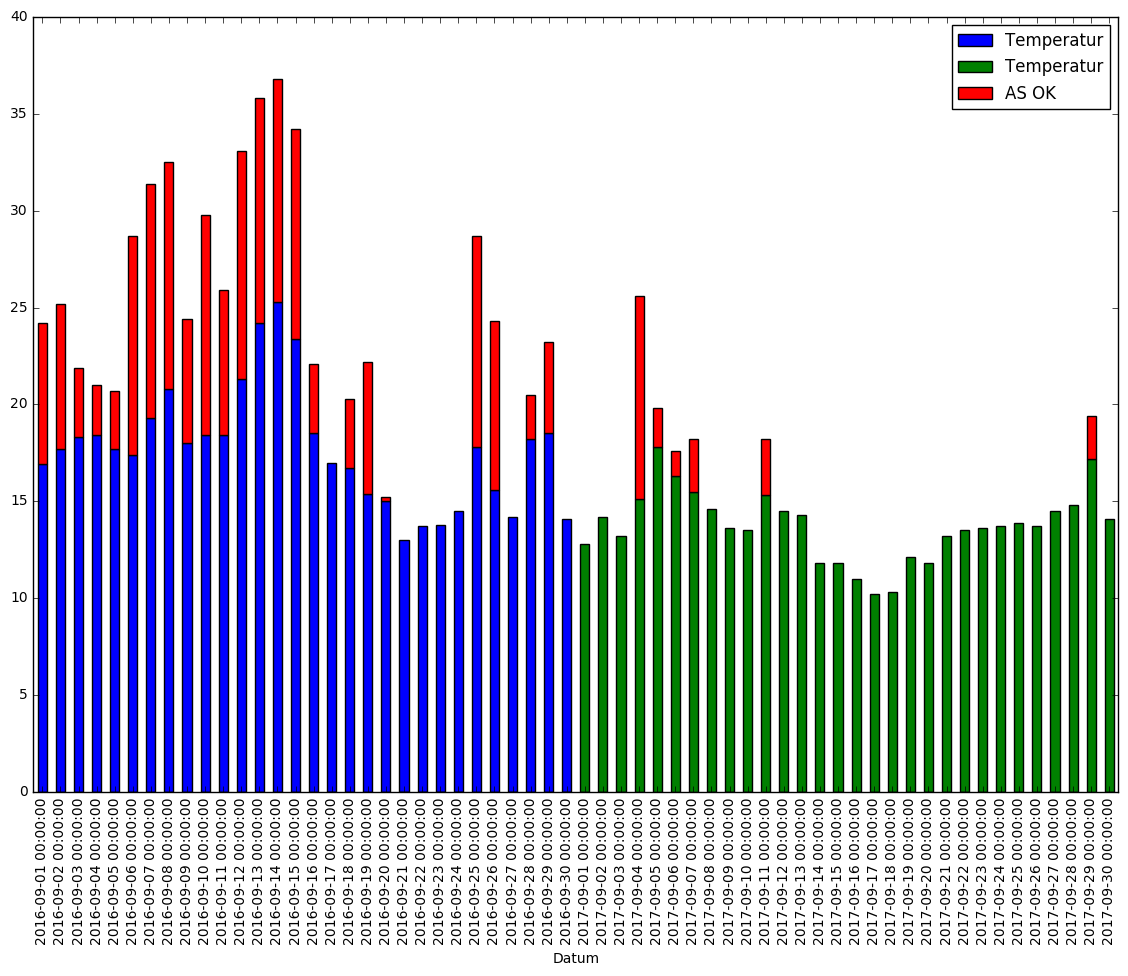

In [391]:
# Temperaturen des Monat September ermitteln
temp_sep = tmp_df[(tmp_df.index.month == 9)][['Temperatur']]

# Nach Jahren trennen
temp_sep_16 = temp_sep[(temp_sep.index.year == 2016)]
temp_sep_17 = temp_sep[(temp_sep.index.year == 2017)]

# Tage für eine AS Behandlung ermitteln, auch nur für den Monat September
as_sep = as_wetter[(as_wetter.index.month == 9)][['Sonnenschein']].rename(columns={'Sonnenschein': 'AS OK'})

# Beides miteinander verbinden und plotten
pd.concat([temp_sep_16, temp_sep_17, as_sep], axis=1).plot(kind='bar', figsize=(14,10), stacked=True)

### September 2017 für eine AS Behandlung ungeeignet?
Nur jene Tage, die einen roten Balken haben, hatten gute Voraussetzungen für eine AS Verdunstung.
Es fällt auf, dass es für eine Langzeitbehandlung keinen Zeitraum gab, in welchem die AS Behandlung unter optimalen Bedingungen hätte stattfinden können. Ausgehend von 10-14 Tagen Behandlungsdauer mit einem Langzeitverdunster, gab es kein adäquates Zeitfenster.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x16a170c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x161dc8400>], dtype=object)

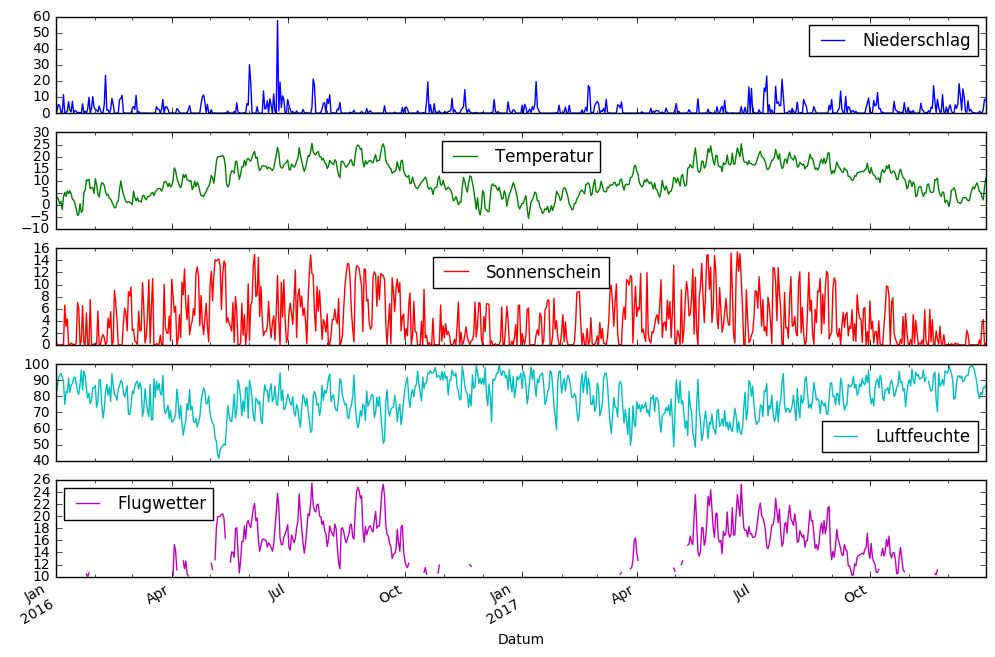

In [392]:
wetter_df.plot(subplots=True, figsize=(12, 8))